# Two dimensional FDTD code for plasmonics

In [121]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

import numpy
from numpy import pi
import pylab
%matplotlib inline

# Simulation libraries:
import fdtd_core as core
import fdtd_excitations as exc
import fdtd_objects as obj
import fdtd_visualization as vis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plasmonic scatterer, reacting to a short pulse

number of nodes : 301 x 201 = 60501 	 time step : 0.00699992864864 	 cycles : 2871
simulation time left:  20 fs, energy:  2211317.3408
simulation time left:  19 fs, energy:  2209985.89817
simulation time left:  18 fs, energy:  2209086.46282
simulation time left:  17 fs, energy:  2199854.93856
simulation time left:  16 fs, energy:  2166140.10921
simulation time left:  15 fs, energy:  2114467.07932
simulation time left:  14 fs, energy:  2115915.14472
simulation time left:  13 fs, energy:  2157724.03622
simulation time left:  12 fs, energy:  2134732.36167
simulation time left:  11 fs, energy:  2110934.40607
simulation time left:  10 fs, energy:  2112862.29133
simulation time left:  9 fs, energy:  2131523.02214
simulation time left:  8 fs, energy:  2141027.98718
simulation time left:  7 fs, energy:  2144945.68125
simulation time left:  6 fs, energy:  2137796.97437
simulation time left:  5 fs, energy:  2111745.46693
simulation time left:  4 fs, energy:  2011012.06566
simulation time left:  

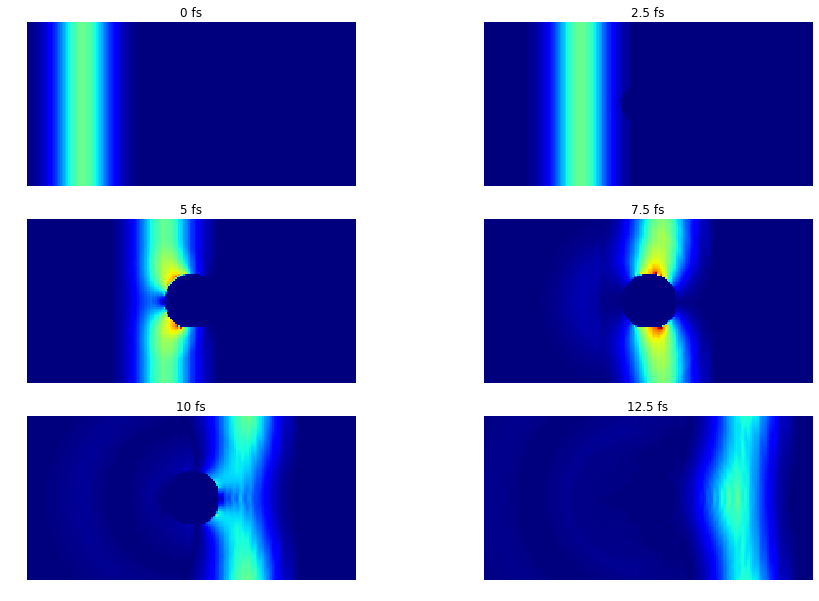

In [269]:
# create a mesh:
lengthx = 9.
lengthy = 6.
Nx = 301                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = core.staggered_grid_2D(lengthx, lengthy, Nx, Ny)

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

# add silver scatterer, using only the Drude parts and an offset
wp = 14.92
wj = 0
gamma = 0.394
sigma = 0
epsinf = 5.976
obj.addDielectricCircle(grid, 
    x=4.5, y=lengthy / 2., R=.5, n=numpy.sqrt(epsinf))
obj.addPlasmonicCircle(grid, 
    x=4.5, y=lengthy / 2., R=.5, wp=wp, wj=wj, gamma=gamma, sigma=sigma)

# for later calculations:
dummy_grid = core.staggered_grid_2D(lengthx, lengthy, Nx, Ny)

# add excitation:
excitations = []
excitations.append(exc.testpulse_x_Exc(x=2.5, H=1, sigma=.5, rc=1))

# the time step is calculated based on the vacuum speed of light
# since we use a material with refractive index > 1, we need to reduce it
dt = grid.dt / 10.
grid.dt = dt
dummy_grid.dt = dt

grid.updateConstants()              # absolutely necessary
t, t_end = 0, 20.1                 # duration of the simulation
cycles = int((t_end - t) / dt)      # total number of cycles
time = numpy.linspace(t, t_end, cycles)

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# list of snapshot times
t_list = [0, 2.5, 5, 7.5, 10, 12.5]
S_list = [] # numpy.zeros((len(t_list), grid.Ex.shape))
Ex_list = []
Ey_list = []
Hz_list = []

# observation of numerical divergences in Ex,Ey,Hz:
bookkeeping = numpy.zeros(cycles)
w_probe = 3


for i in xrange(cycles):             # main loop
    grid.oEx, grid.oEy, grid.oJx, grid.oJy, \
        grid.Ex, grid.Ey, grid.Jx, grid.Jy, grid.Hz = \
            core.CalculationStep(grid, dummy_grid, t, excitations)
    
    
    # calculate the actual absolute value of the Poynting vector:
    S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
    
    # keep a snapshot
    for t0 in t_list:
        if abs(t-t0) < dt / 2:
            S_list.append(S)
            Ex_list.append(grid.Ex)
            Ey_list.append(grid.Ey)
            Hz_list.append(grid.Hz)
            
    
    # keep track of the convergence
    bookkeeping[i] = numpy.sum(S)
    
   
    # print progress:
    if cycles > 20:
        if i % int(cycles / 20) == 0: print "simulation time left: ", int(t_end - t), "fs, energy: ", bookkeeping[i]
            
    t = t + dt

print "done"

# now plot the snapshots
n = len(S_list)
norm = 0.
for i in range(n):
    if norm < S_list[i].max():
        norm = S_list[i].max()

pylab.figure(figsize=(15,10))
for i in range(n):
    pylab.subplot(3,2,i+1)
    vis.plot_matrix(S_list[i], grid, 0)
    pylab.clim(0, norm)
    pylab.axis('off')
    pylab.title(str(t_list[i]) +' fs')
